In [1]:
#Load Libraries needed for notebook

#Install Bioconductor Libraries
BiocManager::install("ChIPpeakAnno", update=F, ask=F)
BiocManager::install("Homo.sapiens", update=F, ask=F)
BiocManager::install("annotate", update=F, ask=F)
BiocManager::install("AnnotationHub", update=F, ask=F)

#Load necessary libraries and suppress startup messages
library(plyr)
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(devtools))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ChIPpeakAnno))
suppressPackageStartupMessages(library(Homo.sapiens))
suppressPackageStartupMessages(library(org.Hs.eg.db))
suppressPackageStartupMessages(library(annotate))
suppressPackageStartupMessages(library(AnnotationHub))


#Color Scheme for PID-specific figures
colors <- c(
            "yellow3", "darkorange", "darkorchid4", "turquoise4",
            "darkgoldenrod2", "lightpink1", "aquamarine3",
            "purple", "blue", "chocolate4", "midnightblue"
           )



Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'ChIPpeakAnno'


package 'ChIPpeakAnno' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Michael\AppData\Local\Temp\RtmpOKNRN3\downloaded_packages


Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'Homo.sapiens'
installing the source package 'Homo.sapiens'

Warning message in install.packages(...):
"installation of package 'Homo.sapiens' had non-zero exit status"Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'annotate'


package 'annotate' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Michael\AppData\Local\Temp\RtmpOKNRN3\downloaded_packages


Bioconductor version 3.9 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'AnnotationHub'


package 'AnnotationHub' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Michael\AppData\Local\Temp\RtmpOKNRN3\downloaded_packages


In [2]:
#Import ISA Data condensing scripts.
#Scripts are freely available for download and use at the link below.


devtools::source_url("https://github.com/michaelbale/RStuff/blob/master/ISADataCondense.R?raw=TRUE")

#Briefly: 2 useful methods are loaded: isadata.condense.singlerun(df) and isadata.condense.multirun(df)
#The overarching method is to combine integration sites in a manner such that the frequency is 
#the maximum of the number of detections at the 3' LTR and 5' LTR for which the detection LTR is 
#in column LTR in the supplied data.frame. multirun requires a column "Sample_run" so as to 
#differentiate between sample types (e.g. tissues or time points) and creates count columns for
#each as well as a total freq column.

SHA-1 hash of file is 13acbf131cb59cf7485432a0281432bd6b4497e3
Loading required package: xlsx


In [3]:
#Read in IS data

#In Vivo data -- CHER
CHER_ISA <- read.table("./CHERISA_unmapped_blinded.txt", header=T, stringsAsFactors=F)
CHER_ISA$PID <- factor(CHER_ISA$PID)
CHER_age <- read.table("./CHERISA_ages.txt", header=T, stringsAsFactors=F)

#In Vivo data -- RID
#PIDs 1079, 2669, 1683, and 3720 are taken from McManus et al. JCI 2019
#N.B. PID 3720 in McManus et al. is described predominently as the viremic control
#ISA data from him was taken from the on-ART time point only
#PIDs 1-5 are taken from Maldarelli, Wu, et al. Science 2014 
RID_ISA <- read.table("./RIDData_unmapped.txt", header=T, stringsAsFactors = F)
RID_ISA$PID <- factor(RID_ISA$PID)

#PBMC Library
PBMC_ISA <- read.table("./PBMCISA_unmapped.txt", header=T, stringsAsFactors=F)

#Display data format -- is consistent throughout
head(CHER_ISA)

PID,Sample_run,chr,bp_pseudo3LTR,LTR,provirus_orientation
<fct>,<chr>,<chr>,<int>,<chr>,<chr>
ZA002,onART,chr7,34482257,5LTR,+
ZA002,onART,chr16,89483345,5LTR,+
ZA002,onART,chr19,47370568,5LTR,-
ZA002,onART,chr4,36141644,5LTR,+
ZA002,onART,chr5,142220392,5LTR,-
ZA002,onART,chr10,73903927,3LTR,-


In [4]:
#Split CHER Data into list of data frames for each patient
CHER_ISA.split <- split(CHER_ISA[,2:6], f=CHER_ISA$PID)

#apply multi-run condense function from previous cell to all dataframes in list
CHER_ISA.cond <- lapply(CHER_ISA.split, FUN = isadata.condense.multirun)

In [5]:
#Handle Patient ZA004:
#on-ART data from ZA004 is from two time points, so will need to make new freq_onART column
#to have consistent columns throughout the CHER_ISA.cond list object
CHER_ISA.cond[["ZA004"]]$freq_onART <- CHER_ISA.cond[["ZA004"]]$freq_onART1 + CHER_ISA.cond[["ZA004"]]$freq_onART2
CHER_ISA.cond[["ZA004"]] <- CHER_ISA.cond[["ZA004"]][,c(1,2,3,8,6,7)]

In [6]:
#clone counter functions for pre and on-ART counts

#pre-ART function has cutoff {num} parameter to define stringent or lax criterion as defined in manuscript
get.preClones <- function(df, cutoff) {
    return(sum(ifelse(df$freq_preART > cutoff, 1, ifelse(df$freq_preART > 0 & df$freq_onART > 0, 1, 0))))
}

#on-ART function has no cutoff parameter as the criterion for single-timepoint detection is greater than 1
get.onClones <- function(df) {
    return(sum(ifelse(df$freq_onART > 1, 1, ifelse(df$freq_preART > 0 & df$freq_onART > 0, 1, 0))))
}

In [7]:
#Summarize ISA count data
ISA_Summ.table <- data.frame(
    #Patient IDs
    PID = names(CHER_ISA.cond),
    #Show total detected LTR-corrected IS in pre-ART by summing freq_preART column
    NumIS_preART = sapply(CHER_ISA.cond, function(x) sum(x$freq_preART)),
    #Count pre-ART clones with stringent criterion
    NumClone_preART.stringent = sapply(CHER_ISA.cond, get.preClones, cutoff = 2),
    #Count pre-ART clones with lax criterion
    NumClone_preART.lax = sapply(CHER_ISA.cond, get.preClones, cutoff=1),
    #Show total detected LTR-corrected IS in on-ART
    NumIS_onART = sapply(CHER_ISA.cond, function(x) sum(x$freq_onART)),
    #Count on-ART clones
    NumClone_onART = sapply(CHER_ISA.cond, get.onClones),
    #Count number of IS that persist through both time points
    NumClone_persist = sapply(CHER_ISA.cond, function(x) sum(x$freq_preART > 0 & x$freq_onART > 0)),
    row.names = NULL
)
                         
#N.B. Patient ZA004 is not handled exactly here
#Persist column could miss IS detected at both on-ART time points but not the pre-ART time point
                         
#N.B. Persist column double dips from the previous clone columns

In [8]:
#Show table
ISA_Summ.table

PID,NumIS_preART,NumClone_preART.stringent,NumClone_preART.lax,NumIS_onART,NumClone_onART,NumClone_persist
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ZA002,1064,27,50,113,9,7
ZA003,1386,7,30,148,16,0
ZA004,655,5,13,255,25,3
ZA005,583,2,14,77,4,1
ZA006,486,1,6,137,20,1
ZA007,197,4,5,85,8,2
ZA008,1293,1,8,225,11,1
ZA009,809,0,16,125,5,0
ZA010,514,1,12,115,3,0


In [9]:
#Function adapted from python code at https://github.com/michaelbale/python_stuff/oligoclonality_index.py

#Calculate Oligoclonality index as described in manuscript and Gillet et al (2011) Blood.
get.OCI <- function(x) {
    x<- x[which(x>0)]
    x <- sort(x, decreasing=T)
    num_sites <- sum(x)
    num_uis <- length(x)
    rel_abun <- x / num_sites
    rel_abun.cum <- cumsum(rel_abun)
    OCI <- 2*(sum(rel_abun.cum/num_uis) - 0.5)
    return(OCI)
}

In [10]:
#Summarize Oligoclonality index values
ISA_Summ.OCI <- data.frame(
    #Get Patient Names
    PID = names(CHER_ISA.cond),
    #Get pre-ART Age (months) from annotation object
    age_preART = CHER_age$Age_preART,
    #Calculate pre-ART OCI from function
    OCI_preART = sapply(CHER_ISA.cond, function(y) round(get.OCI(y$freq_preART), 3)),
    #Get on-ART Age (months) from annotation object
    age_onART = CHER_age$Age_onART,
    #Calculate on-ART OCI from function
    OCI_onART = sapply(CHER_ISA.cond, function(y) round(get.OCI(y$freq_onART), 3)),
    row.names = NULL
)
                        
#N.B. Age here is different from Table 1 in manuscript
#Table 1 has on-ART age in years whereas the annotation object loaded has on-ART age in months
#ZA004 on-ART age is the average of the two on-ART time points

In [11]:
#Show OCI Data
ISA_Summ.OCI


PID,age_preART,OCI_preART,age_onART,OCI_onART
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
ZA002,17.4,0.085,82.44,0.079
ZA003,1.8,0.040,96.72,0.161
ZA004,2.7,0.024,100.08,0.223
ZA005,6.0,0.027,96.48,0.166
ZA006,9.0,0.012,89.40,0.313
ZA007,9.9,0.070,98.88,0.403
ZA008,2.2,0.006,81.24,0.065
ZA009,2.0,0.021,109.56,0.055
ZA010,1.8,0.027,100.20,0.173


In [12]:
#Reshape data for plotting
ISA_Summ.OCI.plot <- data.frame(
    PID = c(names(CHER_ISA.cond), names(CHER_ISA.cond)),
    Age = c(ISA_Summ.OCI$age_preART, ISA_Summ.OCI$age_onART),
    OCI = c(ISA_Summ.OCI$OCI_preART, ISA_Summ.OCI$OCI_onART),
    row.names=NULL
)



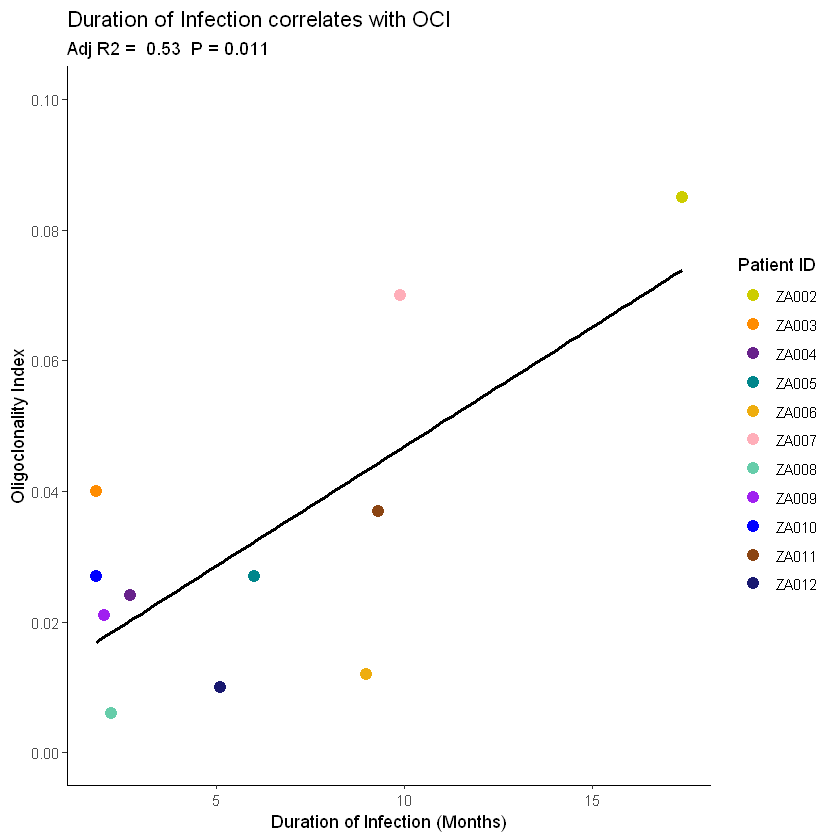

In [13]:
#Linear model of pre-ART OCI as a function of age
#N.B. pre-ART age here is a surrogate for Duration of Infection
fit <- lm(OCI ~ Age, data = ISA_Summ.OCI.plot[1:11,])

#Visualize data
f1a <- ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1], col=ISA_Summ.OCI.plot$PID[1:11])) + 
    #Scatter plot
    geom_point(size=3) +
    
    #Add trend line
    stat_smooth(method = "lm", col = "black", se = F) +
    
    #Labeling
    labs(
         title="Duration of Infection correlates with OCI",
         subtitle = paste("Adj R2 = ",signif(summary(fit)$r.squared, 2),
                          " P =",signif(summary(fit)$coef[2,4], 2)),
         x= "Duration of Infection (Months)",
         y="Oligoclonality Index",
         color="Patient ID"
        )+
    scale_y_continuous(limits=c(0,0.1), breaks = seq(0,0.1,by = 0.02))+
    scale_color_manual(values=colors)+
    
    #Adjust figure theme
    theme_bw()+
    theme(
         panel.border = element_blank(), panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(),
         axis.line = element_line(colour = "black")
         )

f1a

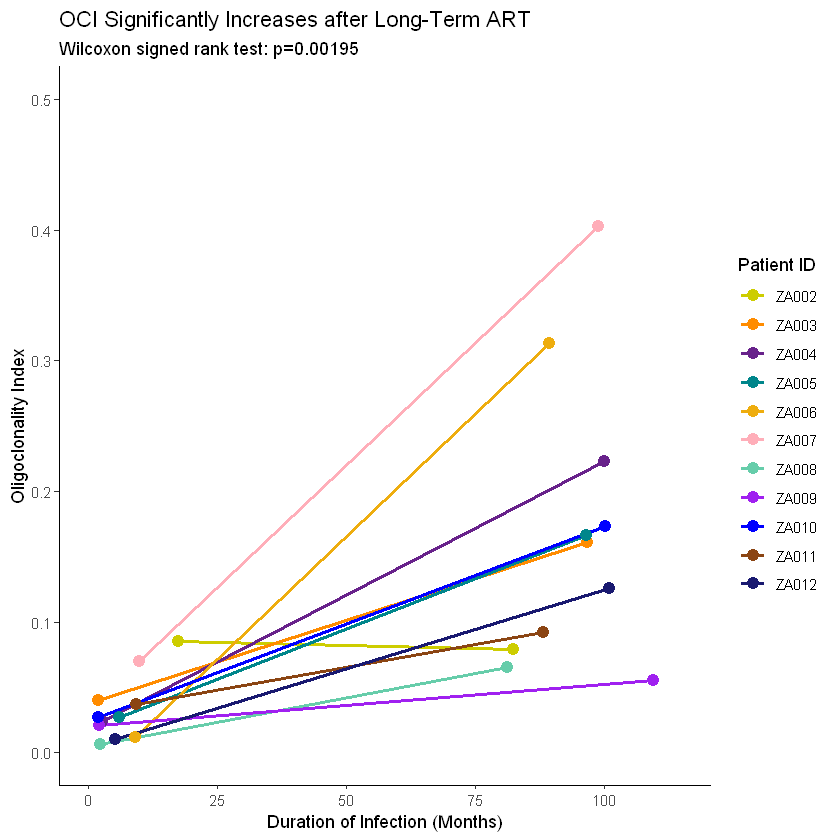

In [14]:
#Analysis of difference in OCI as a function of ART status
fit.2 <- wilcox.test(ISA_Summ.OCI$OCI_preART, ISA_Summ.OCI$OCI_onART, paired = T, exact=T)

#Visualize data
f1b <- ggplot(data=ISA_Summ.OCI.plot, aes(x=Age, y=OCI, col=PID))+
    
    #Add lines between each OCI for each PID
    geom_line(aes(group=PID), size =1)+
    geom_point(size=3)+
    
    #Adjust Figure theme
    theme_bw()+
    theme(
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black")
        )+
    
    #Labeling
    labs(title="OCI Significantly Increases after Long-Term ART",
         subtitle=paste0(fit.2$method,": p=", signif( fit.2$p.value,3)),
         x="Duration of Infection (Months)",
         y="Oligoclonality Index",
         color="Patient ID"
    )+
    scale_color_manual(values=colors)+
    scale_y_continuous(limits = c(0,0.5), breaks=seq(0,0.5,0.1))+
    scale_x_continuous(limits=c(0,115), breaks=seq(0,115,25))

#N.B. Astute observers will note that the statistical test doesn't exactly match the plotted values:
#I.e. the x-axis is on a continuum rather than than grouped together as suggested by the statistical analysis
#We chose to visualize the x-axis on a continuous scale to show that on-ART length does not correlate with OCI
#although not calculated here, it is easily shown that R2 ~= 0 (p>0.05) for that analysis. However, the 
#OCI are dependent on ART status

f1b

In [15]:
#Handle Single-Run Patients versus Multi-Run Patients from RID dataset
RID_ISA.split <- split(RID_ISA[, 2:6], RID_ISA$PID)


#Get number of levels to determine if multi or single
run_type.RID <- sapply(RID_ISA.split, function(x) nlevels(as.factor(x$Sample_run)))

#Split single runs and remove "Sample_run" column
RID_ISA.split.single <- RID_ISA.split[which(run_type.RID == 1)]
RID_ISA.split.single <- lapply(RID_ISA.split.single, function(x) x[,2:5])

#Split Multi runs
RID_ISA.split.multi <- RID_ISA.split[which(run_type.RID > 1)]

In [16]:
#Condense
RID_ISA.sing.cond <- lapply(RID_ISA.split.single, isadata.condense.singlerun)

RID_ISA.multi.cond <- lapply(RID_ISA.split.multi, isadata.condense.multirun)

In [17]:
#Handle column differences
RID_ISA.multi.cond <- lapply(RID_ISA.multi.cond, function(x) x[,c(1:3, ncol(x))])
col.vec <- colnames(RID_ISA.sing.cond[[1]])
RID_ISA.multi.cond <- lapply(RID_ISA.multi.cond, setNames, col.vec)

RID_ISA.cond <- c(RID_ISA.multi.cond, RID_ISA.sing.cond)
RID_ISA.OCI <- sapply(RID_ISA.cond, function(x) get.OCI(x$freq))

In [18]:
#Make Data frame for plotting
Cohort_OCI.comp <- data.frame(
    Cohort=c(rep("Adults", 9), rep("CHER", 11)),
    PID=c(names(RID_ISA.cond), CHER_age$PID),
    OCI=c(RID_ISA.OCI, ISA_Summ.OCI$OCI_onART)    
)

Cohort_OCI.comp

Cohort,PID,OCI
<fct>,<fct>,<dbl>
Adults,1079,0.05243075
Adults,1683,0.10294489
Adults,2669,0.24061207
Adults,PT1,0.26398842
Adults,PT3,0.26038624
Adults,3720,0.17734554
Adults,PT2,0.05555556
Adults,PT4,0.24140809
Adults,PT5,0.05017086


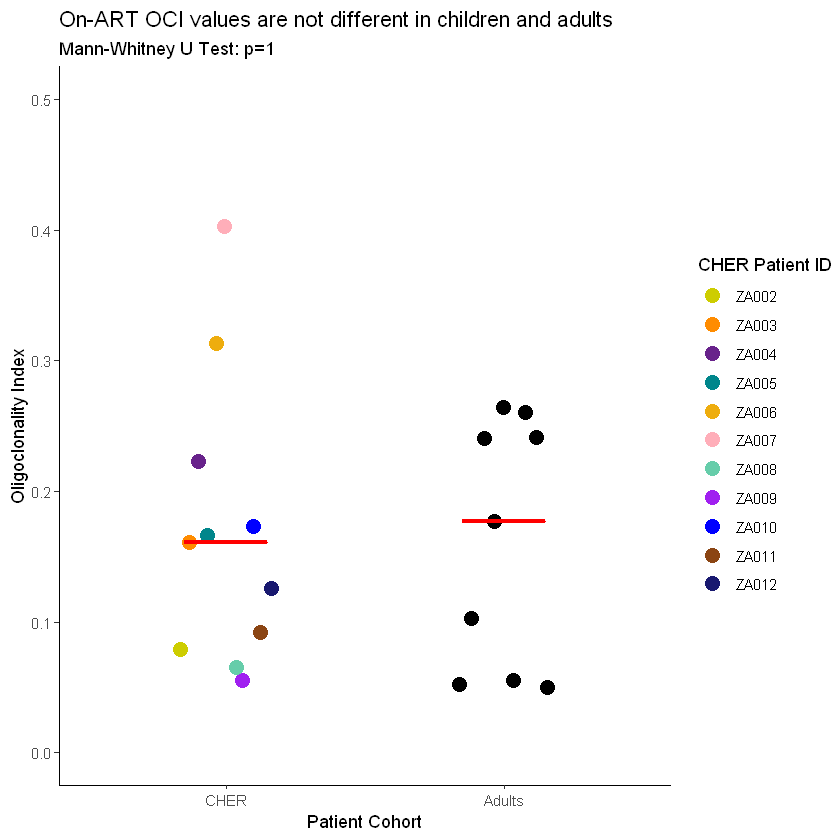

In [19]:
#Analysis of Difference between Adult OCI and CHER OCI
fit.3 <- wilcox.test(Cohort_OCI.comp$OCI[1:9], Cohort_OCI.comp$OCI[10:20], exact = T, paired = F)

#Make Plot
f2 <- ggplot(data = Cohort_OCI.comp, aes(x=Cohort, y=OCI))+
    #Plot Data and add median bars
    geom_point(aes(color=PID), size = 4, position=position_jitterdodge(jitter.width=0.15, dodge.width=0.35))+
    stat_summary(fun.y = median, fun.ymin = median, fun.ymax = median,
                geom="crossbar", width = 0.3, color = "red")+
    
    #Customize Axis/plot labels
    scale_x_discrete(limits=c("CHER", "Adults"))+
    scale_y_continuous(limits=range(0,0.5), breaks=seq(0, 0.5, 0.1))+
    scale_color_manual(values=c(rep("black", 9), colors), breaks=CHER_age$PID, labels=CHER_age$PID)+
    labs(
        title="On-ART OCI values are not different in children and adults",
        subtitle=paste0("Mann-Whitney U Test: p=", fit.3$p.value),
        x="Patient Cohort",
        y="Oligoclonality Index",
        color="CHER Patient ID"
    )+

    #Make look nicer
    theme_bw()+
    theme(
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black")
    )

f2

In [20]:
#Functions for handling Sequence Data for OCI


#Main function to calculate OCI from sequence data
getSeqOCI <- function(seqSet, model="raw") {

    #Assumed all sequences are of same length in the set 
    #Can be changed to get average length or pairwise lengths
    seqLen <- length(seqSet[[1]])
    numSeqs <- length(seqSet)
    #Get pairwise Hamming Distance Matrix
    distMatrix <- dist.dna(as.DNAbin(seqSet), model=model, pairwise.deletion = T, as.matrix = T)
    distMatrix <- distMatrix * seqLen
    
    #Determine identical rake sizes using getRakeList function
    rake_list <- getRakeList(distMatrix, numSeqs)
    rakeCount <- unname(sapply(rake_list, length))
    
    #Fill in unique sequences with 1's to the data set size
    varCounts <- c(rakeCount, rep(1, numSeqs - sum(rakeCount)))

    #Calculate OCI using function from earlier
    seqOCI <- get.OCI(varCounts)

    return(seqOCI)

}

#Auxiliary function for determining rakes
#function adapted from prob_identical.r at https://github.com/michaelbale/prob_identical
getRakeList <- function(distMatrix, numSeqs) {

    rake_list <- list()    

    #Main Looping structure
    for(i in 2:numSeqs){
      
      #rake dummy variable
      in_rake = FALSE
      
      #If sequence is unique, go to next sequence
      if(sum(distMatrix[i-1,i:numSeqs] <0.5) == 0)
        next
      else{
        
        if(length(rake_list) > 0){
          #Create new Rake
          for(j in 1:length(rake_list)){
            if(dimnames(distMatrix)[[1]][i-1] %in% rake_list[[j]]) {
              in_rake = TRUE
              break
            }
          }
          if(in_rake) next
        }
        #add sequence to Rake ID
        rake_list[[paste0("rake",as.character(length(rake_list)+1))]] <- dimnames(distMatrix)[[1]][distMatrix[(i-1),1:numSeqs] == 0]
      }
    }
    return(rake_list)

}

#Load in Sequences from file using ape library
getSeqSet <- function(inPath, format="fasta") {

    require(ape)
    if(!file.exists(inPath)) { stop("Supplied File does not exist") }
    sequences <- ape::read.dna(inPath, format=format, as.character = T, as.matrix = F)
    
    return(sequences)

}

In [21]:
#Get Sequence File Names
CHER.seqDataFiles <- paste(getwd(), "CHER_seqData", dir("./CHER_seqData"), sep="/")

#Load Data
CHER.seqData <- sapply(CHER.seqDataFiles, getSeqSet)

#Calculate OCI
CHER.seqOCI <- sapply(CHER.seqData, getSeqOCI)

#library(ape) loaded in background

Loading required package: ape

Attaching package: 'ape'

The following object is masked from 'package:VennDiagram':

    rotate

The following object is masked from 'package:Biostrings':

    complement

The following object is masked from 'package:ggpubr':

    rotate



In [22]:
#Combine SGS-Based OCI with previous data.frame
ISA_Summ.OCI$seqOCI <- c(NA, round(CHER.seqOCI, 3), NA, NA)

ISA_Summ.OCI

PID,age_preART,OCI_preART,age_onART,OCI_onART,seqOCI
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZA002,17.4,0.085,82.44,0.079,NA
ZA003,1.8,0.040,96.72,0.161,0.714
ZA004,2.7,0.024,100.08,0.223,0.547
ZA005,6.0,0.027,96.48,0.166,0.403
ZA006,9.0,0.012,89.40,0.313,0.450
ZA007,9.9,0.070,98.88,0.403,0.648
ZA008,2.2,0.006,81.24,0.065,0.516
ZA009,2.0,0.021,109.56,0.055,0.217
ZA010,1.8,0.027,100.20,0.173,0.500


In [23]:
#Create Data frame for SGS-based OCI vs ISA-based OCI comparison
CHER_OCI.comp <-
    ISA_Summ.OCI %>%
    #group table by PID
    group_by(PID) %>%
    #Remove Patients with SGS-based OCI
    drop_na() %>%
    #Reshape resulting dataframe
    melt(id.vars="PID") %>%
    #Keep only the OCI data
    filter(variable %in% c("OCI_onART", "seqOCI")) %>%
    #Rename columns from melt command
    dplyr::rename(OCI_type = variable, OCI = value)

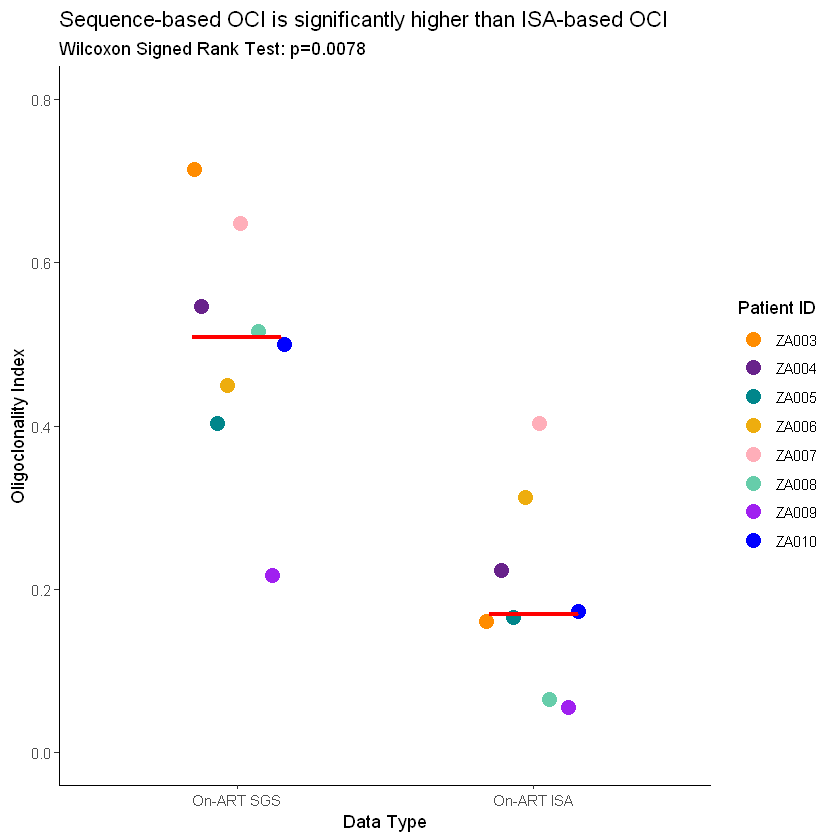

In [24]:
#Analysis of SGS-based OCI vs ISA-based OCI
fit.4 <- wilcox.test(ISA_Summ.OCI$OCI_onART[2:9], ISA_Summ.OCI$seqOCI[2:9], paired=T, exact = T)

#Make Plot
f5 <- ggplot(data = CHER_OCI.comp, aes(x=OCI_type, y=OCI))+
    #Add data and median bars
    geom_point(aes(color=PID), size=4, position=position_jitterdodge(jitter.width = 0.15, dodge.width = 0.35))+
    stat_summary(fun.y = median, fun.ymin = median, fun.ymax=median,
                 geom="crossbar", width = 0.3, color= "red")+
    
    #Customize Axis/plot labels
    scale_color_manual(values=colors[2:9])+
    labs(
        title="Sequence-based OCI is significantly higher than ISA-based OCI",
        subtitle=paste0("Wilcoxon Signed Rank Test: p=", signif(fit.4$p.value, 2)),
        x="Data Type",
        y="Oligoclonality Index",
        color="Patient ID"
    )+
    scale_x_discrete(labels=c("On-ART SGS", "On-ART ISA"), limits=c("seqOCI","OCI_onART"))+
    scale_y_continuous(limits = range(0,0.8), breaks=seq(0, 0.8, 0.2))+
    
    #Make look nicer
    theme_bw()+
    theme(
        panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black")
    )

f5

In [25]:
#Selection and Enrichment analysis of in vivo libraries versus ex vivo library

#get hg19 dataset
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
#retain only genes
hg19.genes <- genes(txdb)

#Data manipulation to remove unscaffolded and unknown regions
hg19 <- data.frame(
    seqnames = seqnames(hg19.genes),
    txStart = start(hg19.genes) - 1,
    txEnd = end(hg19.genes),
    strand = strand(hg19.genes),
    gene_id = hg19.genes$gene_id
)

hg19.edit <- hg19 %>%
    filter(seqnames %in% c(paste0("chr", 1:22), "chrX", "chrY"))

#Create GRanges object for CHiPpeakAnno
hg19.genes <- GRanges(seqnames = as.factor(as.character(hg19.edit$seqnames)),
                      ranges=IRanges(start = hg19.edit$txStart, end = hg19.edit$txEnd, names = hg19.edit$gene_id),
                      strand = hg19.edit$strand
                      )
#Manipulate PBMC library to retain only chromosomes 1 - 22 and X and Y
PBMC_ISA.edit <- PBMC_ISA %>% filter(chr %in% c(paste0("chr", 1:22), "chrX", "chrY"))

#Create GRanges object for CHiPpeakAnno
PBMC_ISA.GRanges <- GRanges(
    seqnames=as.factor(as.character(PBMC_ISA.edit$chr)),
    ranges=IRanges(start=PBMC_ISA.edit$bp_pseudo3LTR, end=PBMC_ISA.edit$bp_pseudo3LTR),
    strand = PBMC_ISA.edit$provirus_orientation
)

#Map PBMC library
PBMC.annotated <- annotatePeakInBatch(PBMC_ISA.GRanges, AnnotationData = hg19.genes, output="shortestDistance", select="first")

In [26]:
#Manipulate condensed ISA data for mapping to genic regions
CHER_ISA.agg <- dplyr::bind_rows(CHER_ISA.cond)
CHER_ISA.agg <- CHER_ISA.agg %>% filter(chr %in% c(paste0("chr", 1:22), "chrX", "chrY"))

#separate pre-ART data
CHER_ISA.pre <- CHER_ISA.agg %>% filter(freq_preART > 0) %>% dplyr::select(chr, bp_pseudo3LTR, provirus_orientation)
CHER_ISA.pre$bp_pseudo3LTR <- as.numeric(CHER_ISA.pre$bp_pseudo3LTR)

#separate on-ART data
CHER_ISA.on  <- CHER_ISA.agg %>% filter(freq_onART > 0) %>% dplyr::select(chr, bp_pseudo3LTR, provirus_orientation)
CHER_ISA.on$bp_pseudo3LTR <- as.numeric(CHER_ISA.on$bp_pseudo3LTR)

In [27]:
#Create pre-ART GRanges object
CHERpre.GRanges <- GRanges(
    seqnames=as.factor(as.character(CHER_ISA.pre$chr)),
    ranges=IRanges(start = CHER_ISA.pre$bp_pseudo3LTR, end = CHER_ISA.pre$bp_pseudo3LTR),
    strand = CHER_ISA.pre$provirus_orientation
)

#Create on-ART GRanges object
CHERon.GRanges <- GRanges(
    seqnames=as.factor(as.character(CHER_ISA.on$chr)),
    ranges=IRanges(start = CHER_ISA.on$bp_pseudo3LTR, end = CHER_ISA.on$bp_pseudo3LTR),
    strand=CHER_ISA.on$provirus_orientation
)

#Map pre-ART data
CHERpre.anno <- annotatePeakInBatch(CHERpre.GRanges, AnnotationData = hg19.genes, output = "shortestDistance", select = "first")
#Map on-ART data
CHERon.anno  <- annotatePeakInBatch(CHERon.GRanges, AnnotationData = hg19.genes, output = "shortestDistance", select = "first")

In [28]:
#convert to dataframes
PBMC_map.df <- data.frame(
    #Factor column for downstream analyses
    sample = "PBMC",
    
    #IS information
    seqnames = seqnames(PBMC.annotated),
    IS = start(PBMC.annotated) - 1,
    IS_strand = strand(PBMC.annotated),
    
    #Host Information
    Gene = getSYMBOL(PBMC.annotated$feature, data='org.Hs.eg'),
    Gene_strand = PBMC.annotated$feature_strand,
    Genic_designation = PBMC.annotated$insideFeature,
    Gene_length = abs(PBMC.annotated$start_position - PBMC.annotated$end_position),
    dist_to_feature = abs(PBMC.annotated$distancetoFeature)
    
)

CHERpre_map.df <- data.frame(
    #Same Scheme as above
    sample = "CHERpre",
    seqnames = seqnames(CHERpre.anno),
    IS = start(CHERpre.anno) - 1,
    IS_strand = strand(CHERpre.anno),
    Gene = getSYMBOL(CHERpre.anno$feature, data='org.Hs.eg'),
    Gene_strand = CHERpre.anno$feature_strand,
    Genic_designation = CHERpre.anno$insideFeature,
    Gene_length = abs(CHERpre.anno$start_position - CHERpre.anno$end_position),
    dist_to_feature = abs(CHERpre.anno$distancetoFeature)
)

CHERon_map.df <- data.frame(
    #Same Scheme as above
    sample = "CHERon",
    seqnames = seqnames(CHERon.anno),
    IS = start(CHERon.anno) - 1,
    IS_strand = strand(CHERon.anno),
    Gene = getSYMBOL(CHERon.anno$feature, data='org.Hs.eg'),
    Gene_strand = CHERon.anno$feature_strand,
    Genic_designation = CHERon.anno$insideFeature,
    Gene_length = abs(CHERon.anno$start_position - CHERon.anno$end_position),
    dist_to_feature = abs(CHERon.anno$distancetoFeature)
)

#Remove factors
PBMC_map.df <- as.data.frame(apply(PBMC_map.df, 2, as.character), stringsAsFactors=FALSE)
CHERpre_map.df <- as.data.frame(apply(CHERpre_map.df, 2, as.character), stringsAsFactors=FALSE)
CHERon_map.df <- as.data.frame(apply(CHERon_map.df, 2, as.character), stringsAsFactors=FALSE)

In [29]:
#Retain genic integrations only
CHERon_genes.df <- CHERon_map.df %>% filter(Genic_designation == "inside")
CHERpre_genes.df <- CHERpre_map.df %>% filter(Genic_designation == "inside")
PBMC_genes.df <- PBMC_map.df %>% filter(Genic_designation == "inside")

#Percent Genic integrations
signif(nrow(PBMC_genes.df)/nrow(PBMC_map.df)*100, 3)

signif(nrow(CHERpre_genes.df)/nrow(CHERpre_map.df)*100, 3)

signif(nrow(CHERon_genes.df)/nrow(CHERon_map.df)*100, 3)

[1] 87.2

[1] 83.9

[1] 76.8

In [30]:
#Bind PBMC and pre-ART mapped data.frames for selection/enrichment analyses
CHERpre_genes.PBMC <- rbind(CHERpre_genes.df, PBMC_genes.df)

#Bind PBMC and on-ART mapped data.frames for selection/enrichment analyses
CHERon_genes.PBMC <- rbind(CHERon_genes.df, PBMC_genes.df)

In [31]:
#fisherTest function for dplyr
fisherTest <- function(w1, w2, a1, a2) {
    w1 <- unlist(w1)
    w1 <- as.numeric(w1)
    w2 <- unlist(w2)
    w2 <- as.numeric(w2)
    a1 <- unlist(a1)
    a1 <- as.numeric(a1)
    a2 <- unlist(a2)
    a2 <- as.numeric(a2)
    
    mat <- matrix(c(w1, w2, a1, a2), nrow=2)
    ft <- fisher.test(mat)
    ft$p.value
}

In [32]:
#Perform orientation bias analysis on pre-ART data
CHERpre_orientation.15 <- CHERpre_genes.PBMC %>%
    #seqnames is here to retain chromosome information in resulting tables
    group_by(seqnames, Gene) %>%
    #Get counts of with/against gene orientations from both libraries
    summarise(
        PBMC_with = sum(IS_strand == Gene_strand & sample == "PBMC"),
        PBMC_against = sum(IS_strand != Gene_strand & sample == "PBMC"),
        PBMC_total = PBMC_with + PBMC_against,
        CHERpre_with = sum(IS_strand == Gene_strand & sample == "CHERpre"),
        CHERpre_against = sum(IS_strand != Gene_strand & sample == "CHERpre"),
        CHERpre_total = CHERpre_with + CHERpre_against
    ) %>%
    #Retain only those with more than 15 IS in vivo and at least one ex vivo
    filter(CHERpre_total >= 15) %>%
    filter(PBMC_total > 0) %>%
    #Arrange in descending order of in vivo IS count
    arrange(desc(CHERpre_total)) %>%
    #remove seqnames grouping for analysis
    ungroup() %>%
    #functionally acts as call to apply(df, 1, FUN)
    group_by(Gene) %>%
    mutate(p.val.raw = fisherTest(PBMC_with, CHERpre_with, PBMC_against, CHERpre_against)) %>%
    #need all data in column
    ungroup() %>%
    #Adjust p-values and sort in ascending order
    mutate(p.val.adj = p.adjust(p.val.raw, "BH")) %>%
    arrange(p.val.adj)

#Show results
CHERpre_orientation.15



seqnames,Gene,PBMC_with,PBMC_against,PBMC_total,CHERpre_with,CHERpre_against,CHERpre_total,p.val.raw,p.val.adj
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
chr6,BACH2,60,72,132,26,5,31,0.0001058293,0.001904928
chr17,STAT5B,284,278,562,24,5,29,0.0008644214,0.007779793
chr16,ANKRD11,380,403,783,3,16,19,0.0046806380,0.028083828
chr22,HORMAD2,192,241,433,11,4,15,0.0340278290,0.153125231
chrX,MECP2,228,267,495,4,12,16,0.1264112860,0.455080629
chr17,VMP1,376,374,750,6,12,18,0.2324184331,0.522941475
chr17,GRB2,339,336,675,11,5,16,0.2053968175,0.522941475
chr17,NPLOC4,418,408,826,5,10,15,0.2036387690,0.522941475
chr17,POLR2A,161,177,338,6,10,16,0.4560647880,0.820916618


In [33]:
#Perform Orientation bias analysis on on-ART data
CHERon_orientation.15 <- CHERon_genes.PBMC %>%
    #Same scheme as previous cell
    group_by(seqnames, Gene) %>%
    summarise(
        PBMC_with = sum(IS_strand == Gene_strand & sample == "PBMC"),
        PBMC_against = sum(IS_strand != Gene_strand & sample == "PBMC"),
        PBMC_total = PBMC_with + PBMC_against,
        CHERon_with = sum(IS_strand == Gene_strand & sample == "CHERon"),
        CHERon_against = sum(IS_strand != Gene_strand & sample == "CHERon"),
        CHERon_total = CHERon_with + CHERon_against
    ) %>%
    filter(CHERon_total >= 15) %>%
    filter(PBMC_total > 0) %>%
    arrange(desc(CHERon_total)) %>%
    ungroup() %>%
    group_by(Gene) %>%
    mutate(p.val.raw = fisherTest(PBMC_with, CHERon_with, PBMC_against, CHERon_against)) %>%
    ungroup()
#No need to adjust p-values as there are only two tests to run.

#Show Results
CHERon_orientation.15

seqnames,Gene,PBMC_with,PBMC_against,PBMC_total,CHERon_with,CHERon_against,CHERon_total,p.val.raw
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
chr17,STAT5B,284,278,562,31,6,37,6.180673e-05
chr6,BACH2,60,72,132,12,4,16,3.360775e-02


In [34]:
#Different fisher test function for enrichment
ftest <- function(x) {
    x <- unlist(x)
    x <- as.numeric(x)
    mat <- matrix(x, nrow = 2)
    ft <- fisher.test(mat)
    ft$p.value
}

In [35]:
#Perform enrichment test on pre-ART data
CHERpre_enrich.df <- CHERpre_genes.PBMC %>%
    #Retain chromosome information and group by Gene
    group_by(seqnames, Gene) %>%
    #Get counts of UIS in each Gene per sample
    #"Out" columns are for facillitation of the ftest function
    summarise(
        PBMC_in = sum(sample=="PBMC"),
        CHERpre_in = sum(sample == "CHERpre"),
        PBMC_out = nrow(PBMC_genes.df) - PBMC_in,
        CHERpre_out = nrow(CHERpre_genes.df) - CHERpre_in
    ) %>%
    #Arrange in Descending order of counts in vivo
    arrange(desc(CHERpre_in)) %>%
    ungroup() 

#Perform enrichment test, adjust p-values, and sort data in ascending order by adjusted p-value
CHERpre_enrich.df$p.val.raw <- apply(CHERpre_enrich.df, 1, function(x) ftest(x[3:6]))
CHERpre_enrich.df$p.val.adj <- p.adjust(CHERpre_enrich.df$p.val.raw, "BH")
CHERpre_enrich.df <- CHERpre_enrich.df[order(CHERpre_enrich.df$p.val.adj),]


In [36]:
#Perform enrichment analysis on on-ART data
CHERon_enrich.df <- CHERon_genes.PBMC %>%
    #Same scheme as above
    group_by(seqnames, Gene) %>%
    summarise(
        PBMC_in = sum(sample=="PBMC"),
        CHERon_in = sum(sample == "CHERon"),
        PBMC_out = nrow(PBMC_genes.df) - PBMC_in,
        CHERon_out = nrow(CHERon_genes.df) - CHERon_in
    ) %>%
    arrange(desc(CHERon_in)) %>%
    ungroup() 

CHERon_enrich.df$p.val.raw <- apply(CHERon_enrich.df, 1, function(x) ftest(x[3:6]))
CHERon_enrich.df$p.val.adj <- p.adjust(CHERon_enrich.df$p.val.raw, "BH")
CHERon_enrich.df <- CHERon_enrich.df[order(CHERon_enrich.df$p.val.adj),]


In [37]:
#Large table; only show relevant results
CHERpre_enrich.df[
    which(
        CHERpre_enrich.df$p.val.adj <0.05 &
        CHERpre_enrich.df$PBMC_in > 0 &
        CHERpre_enrich.df$CHERpre_in > 0
    ), ]

#It is known that STAT5B is selected for in on-ART data, so show value here as well
CHERpre_enrich.df[which(CHERpre_enrich.df$Gene == "STAT5B"),]

seqnames,Gene,PBMC_in,CHERpre_in,PBMC_out,CHERpre_out,p.val.raw,p.val.adj
<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
chr6,BACH2,132,31,335482,7008,7.189016e-21,8.896407e-17


seqnames,Gene,PBMC_in,CHERpre_in,PBMC_out,CHERpre_out,p.val.raw,p.val.adj
<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
chr17,STAT5B,562,29,335052,7010,2.601149e-05,0.1395812


In [38]:
#Large Table; only show relevant results
CHERon_enrich.df[
    which(
        CHERon_enrich.df$p.val.adj <0.05 &
        CHERon_enrich.df$PBMC_in > 0 &
        CHERon_enrich.df$CHERon_in > 0
    ), ]

seqnames,Gene,PBMC_in,CHERon_in,PBMC_out,CHERon_out,p.val.raw,p.val.adj
<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
chr17,STAT5B,562,37,335052,1165,3.237177e-33,3.990468e-29
chr6,BACH2,132,16,335482,1186,4.416282e-19,2.721976e-15


In [39]:
#Create df for orientation analysis
ISA_orientation.global <- data.frame(
    sample = c("PBMC", "pre-ART", "on-ART"),
    with_gene = c(sum(PBMC_genes.df$IS_strand == PBMC_genes.df$Gene_strand),
                  sum(CHERpre_genes.df$IS_strand == CHERpre_genes.df$Gene_strand),
                  sum(CHERon_genes.df$IS_strand == CHERon_genes.df$Gene_strand)),
    against_gene = c(sum(PBMC_genes.df$IS_strand != PBMC_genes.df$Gene_strand),
                     sum(CHERpre_genes.df$IS_strand != CHERpre_genes.df$Gene_strand),
                     sum(CHERon_genes.df$IS_strand != CHERon_genes.df$Gene_strand))
    )

In [40]:
#Adjust df for plotting
ISA_orientation.glb.plot <- ISA_orientation.global %>%
    #Melt to reshape
    melt(id.vars = "sample") %>%
    
    #Factor on Sample column
    group_by(sample) %>%
    
    #Add percent column for bar graph
    dplyr::mutate(percent = value/sum(value)*100) %>%
    
    #adjust column names
    dplyr::rename(Orientation = variable, Count = value) %>%
    
    #Refactor Columns
    ungroup() %>%
    dplyr::mutate(
        sample=factor(sample, levels=c("PBMC", "pre-ART", "on-ART")),
        Orientation=factor(Orientation, levels=c("against_gene", "with_gene"))
    )

In [41]:
#Perform statistical test for orientation analysis

#Data frame structure to pass into stat_pvalue_manual from library(ggpubr)
ISA_orientation.global.tests <- data.frame(
    .y. = c("percent", "percent"),
    group1 = rep("PBMC", 2),
    group2 = c("pre-ART", "on-ART"),
    p = c(
            signif(
                fisher.test(matrix(c(
                        unlist(ISA_orientation.global[1,2:3]),
                        unlist(ISA_orientation.global[2,2:3])
                    ),
                    nrow=2,
                    byrow = T)
                )$p.value,
                2
            ),
            signif(
                fisher.test(matrix(c(
                    unlist(ISA_orientation.global[1,2:3]),
                    unlist(ISA_orientation.global[3,2:3])
                ),
                nrow=2,
                byrow = T)
                )$p.value,
                2
            )
    )
)

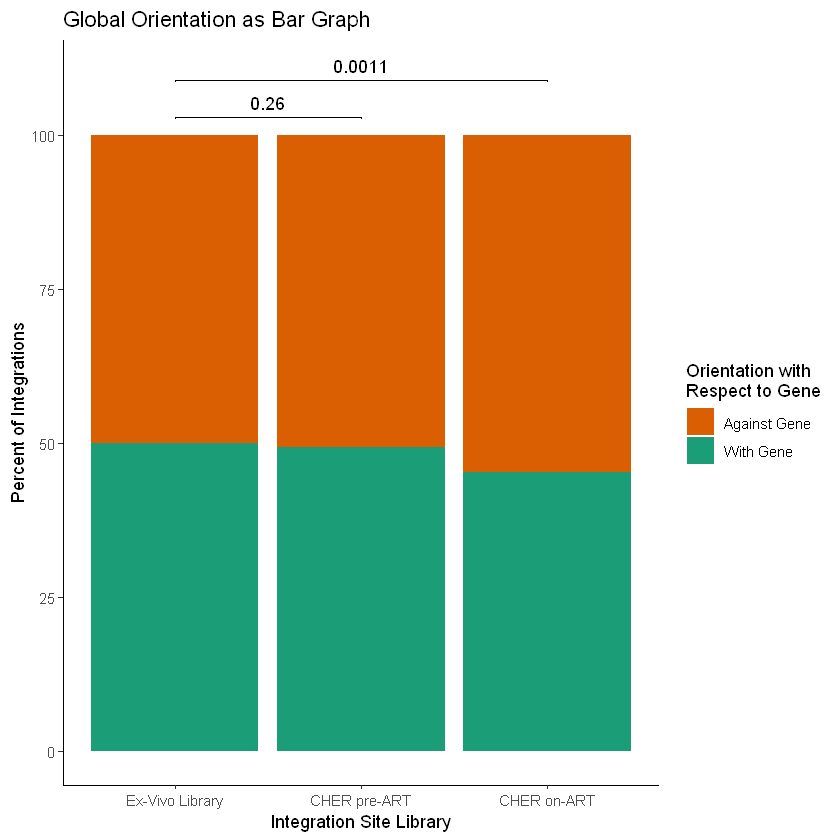

In [42]:
#VIsualize orientation bias analysis

f3b <- ggplot(ISA_orientation.glb.plot, aes(x=sample))+
    
    #Bar graph
    geom_bar(
        aes(
            weight=percent,
            fill=Orientation
        )
    )+

    #Labeling
    scale_x_discrete(
        labels=c(
            "on-ART"="CHER on-ART",
            "PBMC" = "Ex-Vivo Library",
            "pre-ART" = "CHER pre-ART"
        )
    )+
    labs(
        title="Global Orientation as Bar Graph",
        x="Integration Site Library",
        y="Percent of Integrations",
        fill="Orientation with\nRespect to Gene"
    )+
    scale_y_continuous(
        limits=range(0,110),
        labels=seq(0,100,25),
        breaks=seq(0,100,25)
    )+
    scale_fill_manual(
        values=c("#d95f02", "#1b9e77"),
        labels=c("Against Gene", "With Gene")
    )+

    #Create theme
    theme_bw()+
    theme(
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color="black")
    )+

    #Add p-values
    stat_pvalue_manual(ISA_orientation.global.tests, y.pos = c(103, 109))

f3b

In [43]:
#Combine all genic ISA data to single df
ISA_data.all <- dplyr::bind_rows(CHERpre_genes.df, CHERon_genes.df, PBMC_genes.df)

#Create df for orientation analysis for STAT5B and BACH2
ISA_orientation.st5b.b2 <- ISA_data.all %>%

    #Retain Gene and chromosome and factor on sample
    group_by(
        seqnames,
        Gene,
        sample
    ) %>%

    #Get counts of with/against gene orientation
    summarise(
        with_gene = sum(IS_strand == Gene_strand),
        against_gene = sum(IS_strand != Gene_strand),
    ) %>%

    #Retain only STAT5B and BACH2
    filter(
        Gene %in% c("STAT5B", "BACH2")
    ) %>%

    #Reshape
    melt(
        id.vars = c(
            "sample",
            "seqnames",
            "Gene"
            )
        ) %>%
    
    #Regroup for bar-graphs
    ungroup() %>%
    group_by(
        sample,
        Gene
    ) %>%

    #Add percent column
    mutate(
        percent = value/sum(value) * 100
    ) %>%

    #Rename Columns
    dplyr::rename(
        Orientation = variable,
        Count = value
    ) %>%

    #Refactor columns
    ungroup() %>%
    mutate(
        sample = factor(sample, levels=c("PBMC", "CHERpre", "CHERon")),
        Gene = factor(Gene, levels=c("BACH2", "STAT5B")),
        Orientation = factor(Orientation, levels=c("against_gene", "with_gene"))
    )

In [44]:
#Statistical tests for passing into stat_pvalue_manual
#Gene column for facet_wrap
st5b.bach2.tests <- data.frame(
    Gene=c("BACH2", "BACH2", "STAT5B", "STAT5B"),
    group1 = rep("PBMC", 4),
    group2 = c("CHERpre", "CHERon", "CHERpre", "CHERon"),
    p=c(
        signif(
            fisher.test(matrix(c(
                unlist(ISA_orientation.st5b.b2[6,5]),
                unlist(ISA_orientation.st5b.b2[12,5]),
                unlist(ISA_orientation.st5b.b2[5,5]),
                unlist(ISA_orientation.st5b.b2[11,5])
                ),
                nrow=2,
                byrow=T
            )
        )$p.value, 2
    ),
    signif(
        fisher.test(matrix(c(
            unlist(ISA_orientation.st5b.b2[6,5]),
            unlist(ISA_orientation.st5b.b2[12,5]),
            unlist(ISA_orientation.st5b.b2[4,5]),
            unlist(ISA_orientation.st5b.b2[10,5])
            ), nrow=2, byrow=T
        ))$p.value, 2
    ),
    signif(
        fisher.test(matrix(c(
            unlist(ISA_orientation.st5b.b2[3,5]),
            unlist(ISA_orientation.st5b.b2[9,5]),
            unlist(ISA_orientation.st5b.b2[2,5]),
            unlist(ISA_orientation.st5b.b2[8,5])
        ),
        nrow=2,
        byrow=T
        )
        )$p.value, 2
    ),
    signif(
        fisher.test(matrix(c(
            unlist(ISA_orientation.st5b.b2[3,5]),
            unlist(ISA_orientation.st5b.b2[9,5]),
            unlist(ISA_orientation.st5b.b2[1,5]),
            unlist(ISA_orientation.st5b.b2[7,5])
        ),
        nrow=2,
        byrow=T
        )
        )$p.value, 2
    )
      
    ),
    y.position=c(103,109,103,109)
)

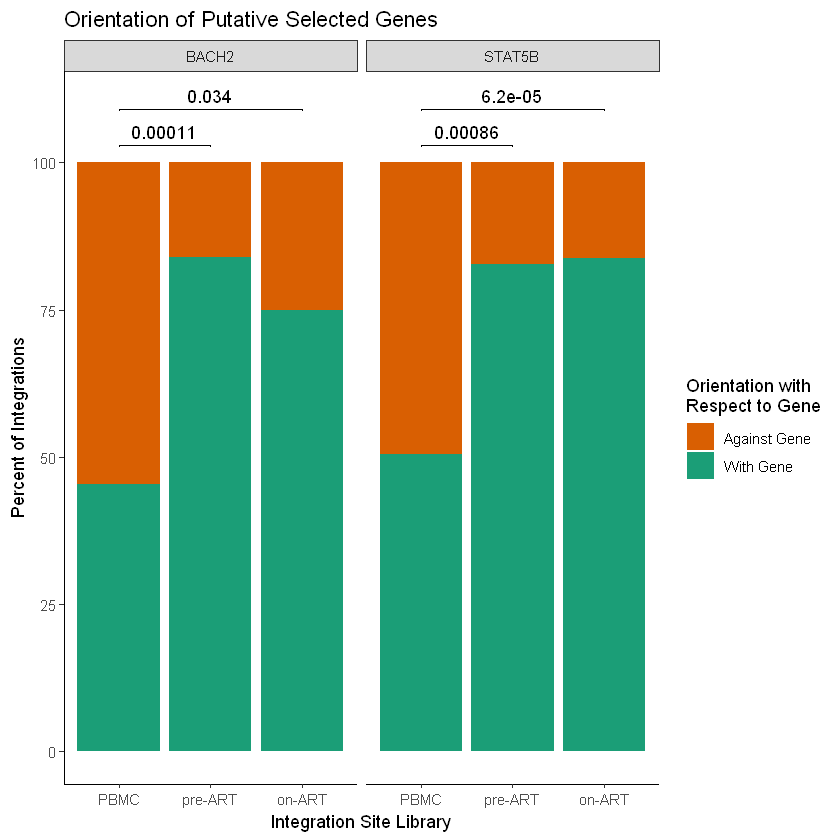

In [45]:
#Plot gene-specific orientation
f3a <- ggplot(ISA_orientation.st5b.b2, aes(x=sample))+
    #Add Bar graph
    geom_bar(
        aes(
            weight=percent,
            fill=Orientation
        )
    )+

    #Create two graphs by Gene
    facet_wrap(~Gene)+

    #Labeling
    scale_x_discrete(
        labels=c(
            "CHERon" = "on-ART",
            "CHERpre" = "pre-ART",
            "PBMC" = "PBMC"
        )
    )+
    labs(
        title="Orientation of Putative Selected Genes",
        x="Integration Site Library",
        y="Percent of Integrations",
        fill="Orientation with\nRespect to Gene"
    )+
    scale_y_continuous(
        limits=c(0,110),
        labels=seq(0,100,25),
        breaks=seq(0,100,25)
    )+
    scale_fill_manual(
        values=c("#d95f02", "#1b9e77"),
        labels=c("Against Gene", "With Gene")
    )+

    #Theme adjusting
    theme_bw()+
    theme(
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color="black")
    )+

    #Add p-values
    stat_pvalue_manual(
        st5b.bach2.tests
    )

f3a

In [46]:
#Get CpG island coordinates
hub <- AnnotationHub()
query(hub, c("cpg","hg19"))
cpgs <- hub[["AH5086"]]

snapshotDate(): 2019-05-02


AnnotationHub with 2 records
# snapshotDate(): 2019-05-02 
# $dataprovider: UCSC
# $species: Homo sapiens
# $rdataclass: GRanges
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH5086"]]' 

           title      
  AH5086 | CpG Islands
  AH5096 | Evo Cpg    

downloading 0 resources
loading from cache 
    'AH5086 : 5086'


In [47]:
#Adjust GRanges object to remove unknown chromosomal locations
cpgs.df <- data.frame(
    seqnames = seqnames(cpgs),
    txStart = start(cpgs) - 1,
    txEnd = end(cpgs),
    strand = strand(cpgs),
    id = as.character(cpgs$name)
)

cpgs.df.edit <- cpgs.df %>%
    filter(seqnames %in% c(paste0("chr", 1:22), "chrX", "chrY"))

#Create GRanges object
cpgs.granges <- GRanges(
    seqnames = as.factor(as.character(cpgs.df.edit$seqnames)),
    ranges = IRanges(
        start = cpgs.df.edit$txStart,
        end = cpgs.df.edit$txEnd,
        names = cpgs.df.edit$id
        )
)

In [48]:
#Annotate IS data -- distance to middle of CpG Island
PBMC_cpgs.annotated <- annotatePeakInBatch(
    PBMC_ISA.GRanges,
    AnnotationData = cpgs.granges,
    output="shortestDistance",
    select="first",
    FeatureLocForDistance="middle"
)

CHERpre_cpgs.anno <- annotatePeakInBatch(
    CHERpre.GRanges,
    AnnotationData = cpgs.granges,
    output = "shortestDistance",
    select = "first",
    FeatureLocForDistance="middle"
)

CHERon_cpgs.anno <- annotatePeakInBatch(
    CHERon.GRanges,
    AnnotationData = cpgs.granges,
    output = "shortestDistance",
    select = "first",
    FeatureLocForDistance="middle"
)

In [49]:
#Get absolute distances
PBMC_cpg.df <- data.frame(
    sample = "PBMC",
    distance = abs(PBMC_cpgs.annotated$distancetoFeature),
    stringsAsFactors = FALSE
) %>%
    mutate(
        log_dist = log10(distance)
    )

CHERpre_cpg.df <- data.frame(
    sample = "CHERpre",
    distance = abs(CHERpre_cpgs.anno$distancetoFeature),
    stringsAsFactors = FALSE
) %>%
    mutate(
        log_dist = log10(distance)
    )

CHERon_cpg.df <- data.frame(
    sample = "CHERon",
    distance = abs(CHERon_cpgs.anno$distancetoFeature),
    stringsAsFactors = FALSE
) %>%
    mutate(
        log_dist = log10(distance)
    )

CPG_dists <- dplyr::bind_rows(PBMC_cpg.df, CHERpre_cpg.df, CHERon_cpg.df) %>%
    mutate(sample = factor(sample, levels=c("PBMC", "CHERpre", "CHERon"))) %>%
    filter(log_dist > -Inf)

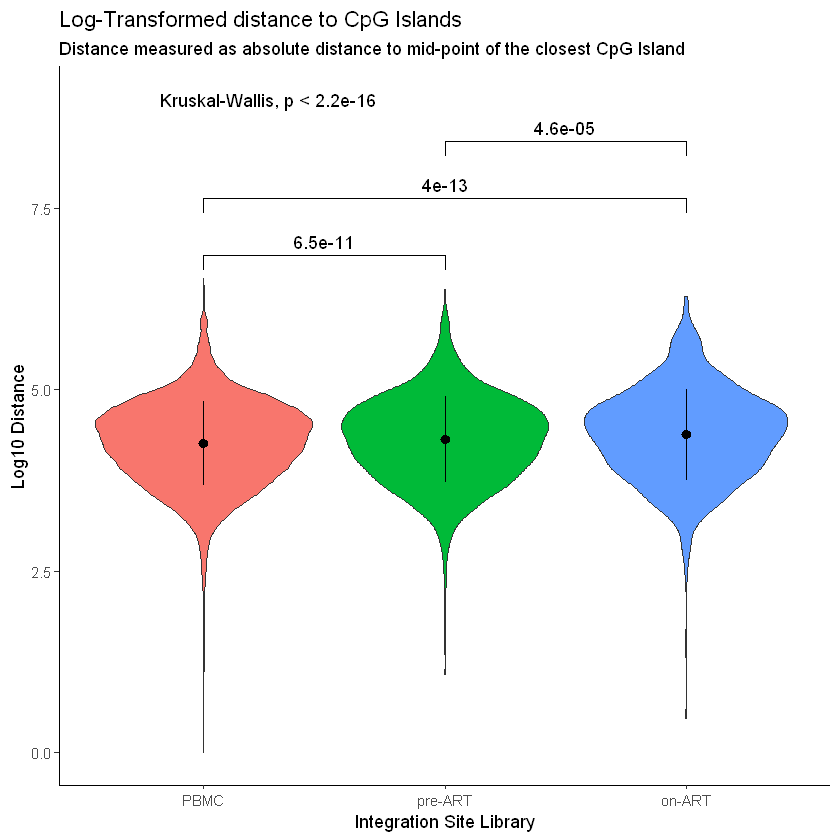

In [50]:
#Helper function for scale bars in violin plots
data_summary <- function(x) {
    m <- mean(x)
    ymin <- m-sd(x)
    ymax <- m+sd(x)
    return(c(y=m,ymin=ymin,ymax=ymax))
}

#Comparisons helper variable
comparisons <- list(c("PBMC", "CHERpre"), c("PBMC", "CHERon"), c("CHERpre", "CHERon"))

#Plot CpG island analysis
sf1a <- ggplot(CPG_dists, aes(x = sample, y = log_dist, fill = sample))+
    #Add violin plot
    geom_violin() +
    
    #Add statistical tests: Kruskal Wallis
    stat_compare_means(label.y=9)+
    #Add statistical tests: Mann-Whitney
    stat_compare_means(comparisons = comparisons)+
    #Add mean +/- sd bars
    stat_summary(fun.data=data_summary)+
    
    #Labelling
    labs(
        title="Log-Transformed distance to CpG Islands",
        subtitle="Distance measured as absolute distance to mid-point of the closest CpG Island",
        y="Log10 Distance",
        x="Integration Site Library"
    )+
    scale_x_discrete(labels=c("PBMC", "pre-ART", "on-ART"))+
    scale_fill_discrete(guide=FALSE)+
    
    #Adjust Theme
    theme_bw()+
    theme(
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color="black")
    )

sf1a

In [51]:
#Summarise results
CPG_dists.summary <- CPG_dists %>% 
    group_by(sample) %>%
    summarise(
        meanLDist = mean(log_dist),
        medianLDist = median(log_dist),
        meanDist = mean(distance),
        medianDist = median(distance)
    )

CPG_dists.summary

sample,meanLDist,medianLDist,meanDist,medianDist
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
PBMC,4.260883,4.294488,43326.72,19701.0
CHERpre,4.309268,4.329622,51304.49,21361.0
CHERon,4.379041,4.401047,66128.00,25179.5


In [52]:
#Pull distance data from aggregated mapped genic data

#Various distance transforms -- analysis only on normalized distance
ISA_data.tss <- data.frame(
    sample = ISA_data.all$sample,
    raw_dist = as.numeric(ISA_data.all$dist_to_feature),
    raw_dist.log = log10(as.numeric(ISA_data.all$dist_to_feature)),
    norm_dist = as.numeric(ISA_data.all$dist_to_feature) / as.numeric(ISA_data.all$Gene_length)
)

#Refactor and remove 0s
ISA_data.tss <- ISA_data.tss %>%
    mutate(
        sample = factor(sample, levels=c("PBMC", "CHERpre", "CHERon"))
    ) %>%
    filter(raw_dist.log > -Inf)

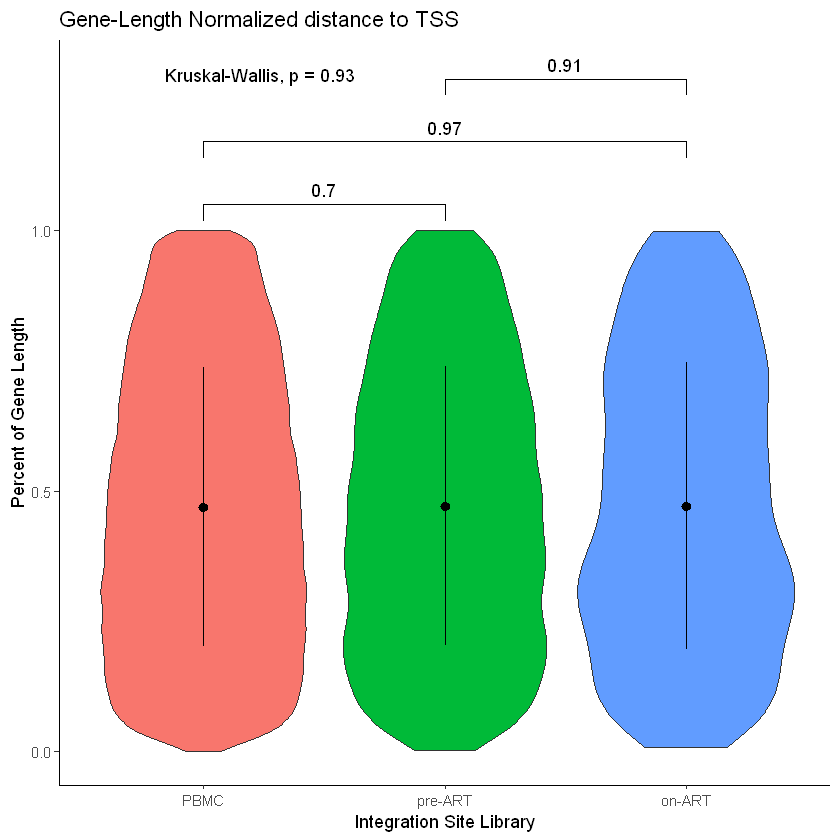

In [53]:
#Plot TSS-distance
sf1b <- ggplot(ISA_data.tss, aes(x = sample, y = norm_dist, fill = sample))+
    #Add Violin Plot
    geom_violin()+

    #Statistical Tests
    stat_compare_means(label.y=1.3)+
    stat_compare_means(comparisons = comparisons)+
    stat_summary(fun.data=data_summary)+
    
    #Labeling
    labs(
        title="Gene-Length Normalized distance to TSS",
        y="Percent of Gene Length", 
        x="Integration Site Library"
    )+
    scale_x_discrete(labels=c("PBMC", "pre-ART", "on-ART"))+
    scale_fill_discrete(guide=F)+
    
    #Adjust Theme
    theme_bw()+
    theme(
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color="black")
    )

sf1b

In [54]:
#Summarise data and show
ISA_data.tss %>%
    group_by(sample) %>%
    summarise(
        min.Raw = min(raw_dist),
        avg.Raw = mean(raw_dist),
        med.Raw = median(raw_dist),
        max.Raw = max(raw_dist),
        min.logRaw = min(raw_dist.log),
        avg.logRaw = mean(raw_dist.log),
        med.logRaw = median(raw_dist.log),
        max.logRaw = max(raw_dist.log),
        min.norm = min(norm_dist),
        avg.norm = mean(norm_dist),
        med.norm = median(norm_dist),
        max.norm = max(norm_dist)
    )

sample,min.Raw,avg.Raw,med.Raw,max.Raw,min.logRaw,avg.logRaw,med.logRaw,max.logRaw,min.norm,avg.norm,med.norm,max.norm
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PBMC,1,52293.45,26878,2507730,0.000000,4.407694,4.429397,6.399281,4.865457e-05,0.4692756,0.4535210,0.9999828
CHERpre,24,56981.53,27445,1371397,1.380211,4.425720,4.438463,6.137163,2.010407e-03,0.4705026,0.4584621,0.9999171
CHERon,389,74972.29,32271,3471878,2.589950,4.501871,4.508812,6.540564,8.110080e-03,0.4706365,0.4395921,0.9980965


In [55]:
#If you would like to download the figures as a powerpoint from this jupyter doc, use the following code

#create_pptx function taken from https://www.brodrigues.co/blog/2018-10-05-ggplot2_purrr_officer/

#install.packages("officer")
#install.packages("rvg")
#library("officer")
#library("rvg")

#create_pptx <- function(plot, path){
#    if(!file.exists(path)) {
#        out <- read_pptx()
#    } else {
#        out <- read_pptx(path)
#    }
#    
#    out %>%
#        add_slide(layout = "Title and Content", master = "Office Theme") %>%
#        ph_with_vg(code = print(plot), type = "body") %>% 
#        print(target = path)
#}

#create_pptx(f1a, "path")
#create_pptx(f1b, "path")
#create_pptx(f2, "path")
#create_pptx(f3a, "path")
#create_pptx(f3b, "path")
#create_pptx(f5, "path")
#create_pptx(sf1a, "path")
#create_pptx(sf1b, "path")
